# CNN Cancer Detection Kaggle Mini-Project

##  Problem Definition
This is a project to use Kaggle's Histopathologic Cancer Detection competition to do exploratory data analysis (EDA), model building and training, and comparison with deep learning. 
In this case, the technique we will be exploring is **Convolutional Neural Networks**. 

Information about the competition can be found at https://www.kaggle.com/c/histopathologic-cancer-detection/overview.
The goal will be to create a model that can identify metastatic cancer in small image patches taken from larger pathology scans. 

### Dataset Information
The data is from the Kaggle competition. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset. They are small pathology images to be classified. Files are named with an image id and train_labels.csv contains the ground truth for the images. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

In [22]:
import os
import numpy as np
import pandas as pd
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from skimage import filters
from PIL import Image
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

In [2]:
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')
sub = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_path = '../input/histopathologic-cancer-detection/train/'
test_path = '../input/histopathologic-cancer-detection/test/'

In [3]:
# find out how many images are in train/test
print(f'{len(os.listdir(train_path))} pictures in train.')
print(f'{len(os.listdir(test_path))} pictures in test.')

220025 pictures in train.
57458 pictures in test.


In [4]:
#Splitting data into train and val
train, val = train_test_split(labels, stratify=labels.label, test_size=0.1)
len(train), len(val)

(198022, 22003)

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data
I will view the data and determine if it needs cleaning. The Kaggle competition specified that there are no duplicates, so we don't need to check for that. We also already know the images are 32x32 pixels.

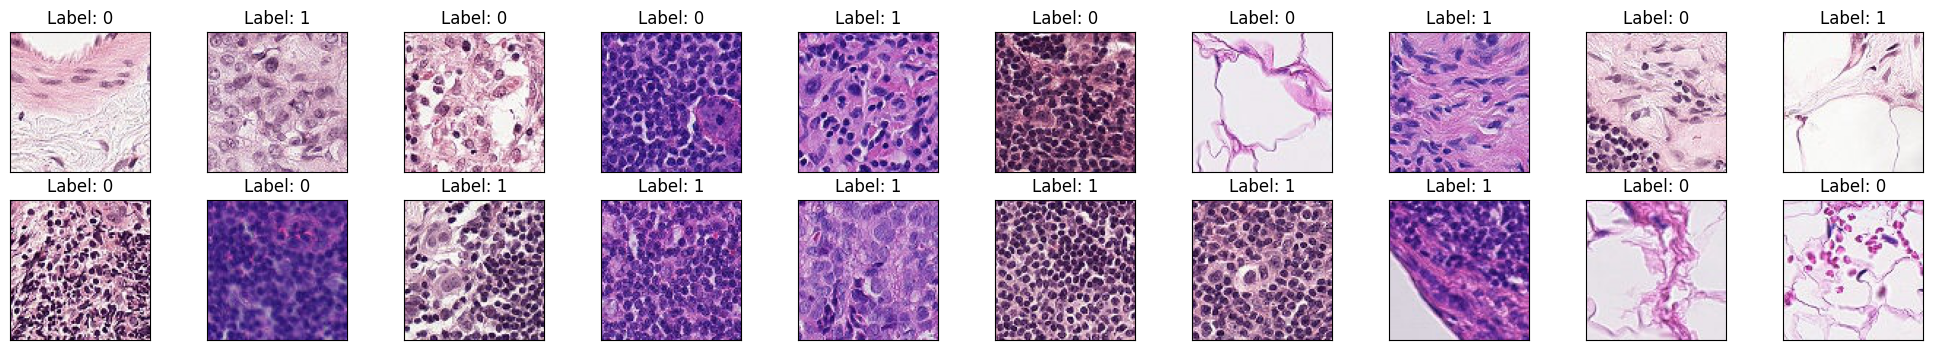

In [9]:
# Let's preview some of the training images
# A positive label (1) means that cancer cells are present
fig = plt.figure(figsize=(25, 4))

train_imgs = os.listdir(train_path)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(train_path + img)
    plt.imshow(im)
    lab = labels.loc[labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

These images don't have much meaning to me since I'm not a biologist. Maybe edges are important or pixel intensities, so let's view some histograms for that.

In [12]:
# It takes way too long to run tests on the entire dataset so I'm going to make a randomizer to pick a few to look at
def load_random_images(train_path, labels, num_images=500):
    all_images = os.listdir(train_path)
    random_images = random.sample(all_images, num_images)
    
    images_info = []  # List to store (image, label) pairs
    
    # Load images and retrieve their labels
    for img_name in random_images:
        img_id = img_name.split('.')[0]  # Get the ID (assumes filenames are like 'img1.jpg')
        img_label = labels.loc[labels['id'] == img_id, 'label'].values[0]
        img_path = os.path.join(train_path, img_name)
        img = Image.open(img_path)
        images_info.append((img, img_label))
    
    return images_info

# Load 500 random images and their labels
images_info = load_random_images(train_path, labels)

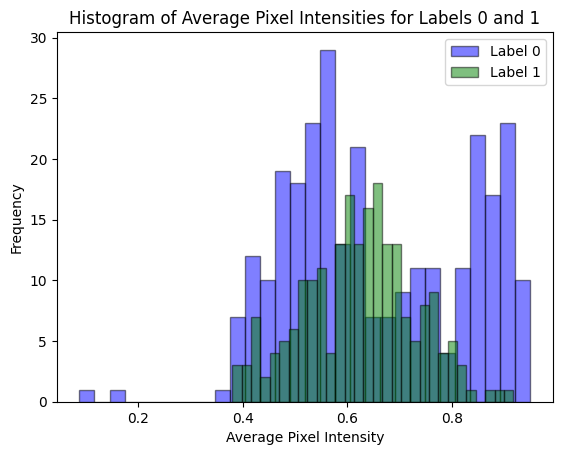

In [13]:
# Plot pixel intensities to understand the contrast of the images and detect any imbalance
# Initialize lists for average intensities of label 0 and label 1
avg_intensities_0 = []
avg_intensities_1 = []

# Transform to tensor
transform = transforms.ToTensor()

# Separate images into two groups based on their labels
for img, label in images_info:
    img_tensor = transform(img)  # Convert image to tensor
    avg_intensity = img_tensor.mean().item()  # Compute average pixel intensity
    
    if label == 0:
        avg_intensities_0.append(avg_intensity)
    elif label == 1:
        avg_intensities_1.append(avg_intensity)

# Plot histograms for each label
plt.hist(avg_intensities_0, bins=30, color='blue', alpha=0.5, label='Label 0', edgecolor='black')
plt.hist(avg_intensities_1, bins=30, color='green', alpha=0.5, label='Label 1', edgecolor='black')
plt.title('Histogram of Average Pixel Intensities for Labels 0 and 1')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The distrubtions of average pixel intensity are pretty different depending on the label. That seems promising for being able to use a low-complexity CNN.

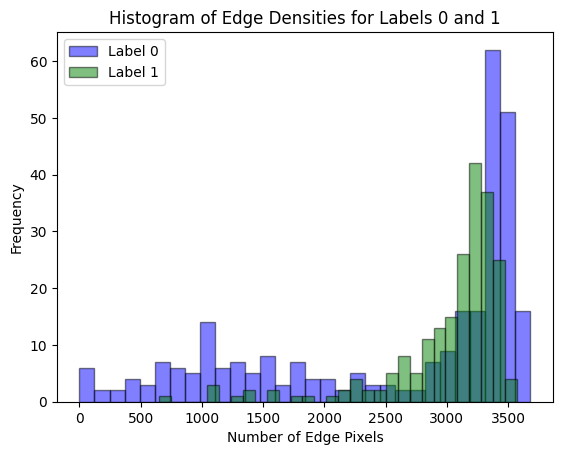

In [15]:
# I think maybe edges might be important for cancer cells, so lets look at a histogram of edge distributions.
# Initialize lists for edge densities of label 0 and label 1
edge_counts_0 = []
edge_counts_1 = []

# Edge detection using Canny
def detect_edges(image):
    # Convert PIL image to OpenCV format (numpy array)
    image_np = np.array(image)
    # Apply Canny edge detection
    edges = cv2.Canny(image_np, 100, 200)  # Use thresholds 100 and 200 for edge detection
    return edges

# Process images to compute edge densities
for img, label in images_info:
    edges = detect_edges(img)
    edge_count = np.sum(edges == 255)  # Count pixels where edges are detected (255)
    
    if label == 0:
        edge_counts_0.append(edge_count)
    elif label == 1:
        edge_counts_1.append(edge_count)

# Plot histograms for each label
plt.hist(edge_counts_0, bins=30, color='blue', alpha=0.5, label='Label 0', edgecolor='black')
plt.hist(edge_counts_1, bins=30, color='green', alpha=0.5, label='Label 1', edgecolor='black')
plt.title('Histogram of Edge Densities for Labels 0 and 1')
plt.xlabel('Number of Edge Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

I think the difference between the two is a little less clear here, so maybe a simple CNN won't quite cut it or maybe edge density isn't that important.

In [16]:
# Let's check for class imbalance
labels.label.value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

The classes seem balanced enough. I don't think the dataset needs to be modified.

## Model Architecture
I'm going to start with a shallow network of 3 convolutional layers because the image size is relatively small. I'm also going to use pooling to downsample the images to 4x4 before reaching the fully connected layers. I'll add in a dropout layer to help prevent overfitting. I'll use sigmoid activation because I'm doing binary classification. 
If that doesn't go well I will try a CNN with more convolutional layers and a different pooling layout. I think this extra depth might help if the cancer pattern is too complex for the original model. I'm not using it first because it has a higher computational cost. 

In [5]:
## Parameters for model

# Hyper parameters
num_epochs = 5
num_classes = 2
batch_size = 128
learning_rate = 0.001

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# Here's a basic custom generator
class MyDataset(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [7]:
# Load data in
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(64, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

dataset_train = MyDataset(df_data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(df_data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [25]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        # First convolutional block: Conv2D -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 128)  # Adjusted size
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)  # Output layer for binary classification

    def forward(self, x):
        # Apply first convolutional block
        x = self.pool(F.relu(self.conv1(x)))
        
        # Apply second convolutional block
        x = self.pool(F.relu(self.conv2(x)))
        
        # Apply third convolutional block
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 128 * 28 * 28)  # Reshape to (batch_size, flattened_size)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Sigmoid activation for binary classification
        return torch.sigmoid(x)


## Results and Analysis
I'm going to try training the model now. 
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary. 

In [28]:
# Let's prepare the model
model = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy with Logits Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device).float()  # Ensure labels are float
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

Epoch [1/5], Step [100/1548], Loss: 0.6931
Epoch [1/5], Step [200/1548], Loss: 0.6931
Epoch [1/5], Step [300/1548], Loss: 0.6931
Epoch [1/5], Step [400/1548], Loss: 0.6931
Epoch [1/5], Step [500/1548], Loss: 0.6931
Epoch [1/5], Step [600/1548], Loss: 0.6931
Epoch [1/5], Step [700/1548], Loss: 0.6931
Epoch [1/5], Step [800/1548], Loss: 0.6931
Epoch [1/5], Step [900/1548], Loss: 0.6931
Epoch [1/5], Step [1000/1548], Loss: 0.6931
Epoch [1/5], Step [1100/1548], Loss: 0.6931
Epoch [1/5], Step [1200/1548], Loss: 0.6931
Epoch [1/5], Step [1300/1548], Loss: 0.6931
Epoch [1/5], Step [1400/1548], Loss: 0.6931
Epoch [1/5], Step [1500/1548], Loss: 0.6931
Epoch [1/5], Average Loss: 0.6932
Epoch [2/5], Step [100/1548], Loss: 0.6931
Epoch [2/5], Step [200/1548], Loss: 0.6931
Epoch [2/5], Step [300/1548], Loss: 0.6931
Epoch [2/5], Step [400/1548], Loss: 0.6931
Epoch [2/5], Step [500/1548], Loss: 0.6931
Epoch [2/5], Step [600/1548], Loss: 0.6931
Epoch [2/5], Step [700/1548], Loss: 0.6931
Epoch [2/5], S

KeyboardInterrupt: 

The loss isn't changing at all so that's concerning. I ended testing early since it's taking a significant amount of time to run. I'm going to switch to a CNN model architecture that has batch normalization and use cross entropy loss instead. I'm also going to use leaky relu because it seemed like the last model was suffering from vanishing gradients.

In [16]:
class LayeredCNN(nn.Module):
    def __init__(self):
        super(LayeredCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AdaptiveAvgPool2d((3, 3))
        self.fc = nn.Linear(128 * 3 * 3, 2)  # Output for binary classification

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.avg(x)
        x = x.view(-1, 128 * 3 * 3)  # Flatten
        x = self.fc(x)  # Output layer
        return x

In [18]:
# Let's prepare the model
model = LayeredCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')

Epoch [1/5], Step [100/1548], Loss: 0.4942
Epoch [1/5], Step [200/1548], Loss: 0.4302
Epoch [1/5], Step [300/1548], Loss: 0.3583
Epoch [1/5], Step [400/1548], Loss: 0.3186
Epoch [1/5], Step [500/1548], Loss: 0.3239
Epoch [1/5], Step [600/1548], Loss: 0.3851
Epoch [1/5], Step [700/1548], Loss: 0.3655
Epoch [1/5], Step [800/1548], Loss: 0.3942


KeyboardInterrupt: 

It looks like the model has overshot a bit with loss, but so far this model seems more promising than the last one. I ended testing early since it's taking a significant amount of time to run. I'm going to lower the learning rate and see if that helps with the loss increasing.

In [19]:
learning_rate = 0.0005

model = LayeredCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(loader_train)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Adjust for output shape
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)  # Accumulate loss
        
        if (i+1) % 100 == 0:  # Print every 100 steps
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
    
    epoch_loss = running_loss / len(loader_train.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {epoch_loss:.4f}')


Epoch [1/5], Step [100/1548], Loss: 0.4066
Epoch [1/5], Step [200/1548], Loss: 0.3869
Epoch [1/5], Step [300/1548], Loss: 0.3490
Epoch [1/5], Step [400/1548], Loss: 0.4214
Epoch [1/5], Step [500/1548], Loss: 0.3774
Epoch [1/5], Step [600/1548], Loss: 0.2659
Epoch [1/5], Step [700/1548], Loss: 0.3789
Epoch [1/5], Step [800/1548], Loss: 0.3195
Epoch [1/5], Step [900/1548], Loss: 0.3300
Epoch [1/5], Step [1000/1548], Loss: 0.3051
Epoch [1/5], Step [1100/1548], Loss: 0.3003
Epoch [1/5], Step [1200/1548], Loss: 0.3473
Epoch [1/5], Step [1300/1548], Loss: 0.2590
Epoch [1/5], Step [1400/1548], Loss: 0.3016
Epoch [1/5], Step [1500/1548], Loss: 0.3036
Epoch [1/5], Average Loss: 0.3623
Epoch [2/5], Step [100/1548], Loss: 0.2725
Epoch [2/5], Step [200/1548], Loss: 0.2953
Epoch [2/5], Step [300/1548], Loss: 0.3082
Epoch [2/5], Step [400/1548], Loss: 0.3415
Epoch [2/5], Step [500/1548], Loss: 0.2901
Epoch [2/5], Step [600/1548], Loss: 0.3427
Epoch [2/5], Step [700/1548], Loss: 0.3617
Epoch [2/5], S

Lowering the learning rate didn't really help much with the loss. I think this model could probably use a learning rate scheduler. But let's see how good the accuracy is on the testing images.

In [23]:
# Test the model
y_true = []
y_pred = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        # Store the true and predicted labels
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 22003 test images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 22003 test images: 85.65195655137936 %


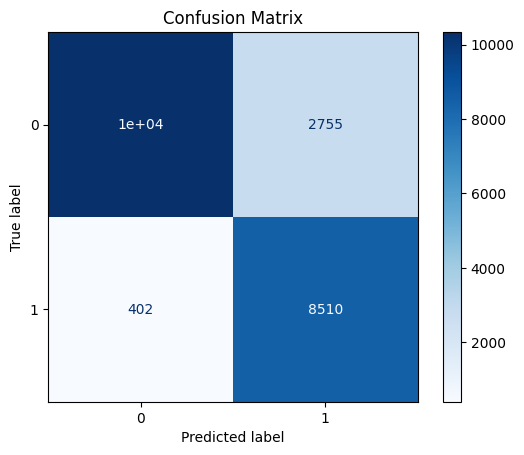

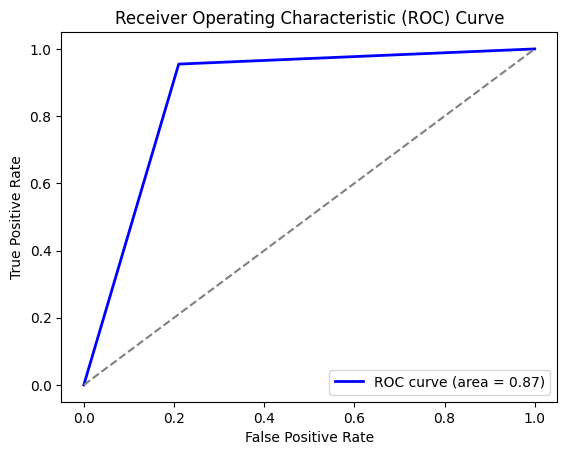

In [24]:
# Let's view the confusion matrix of test data and the ROC Curve and AUC Score
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Kaggle submission stuff
dataset_valid = MyDataset(df_data=sub, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)
    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
sub.shape, len(preds)
sub['label'] = preds
sub.to_csv('submission.csv', index=False)

## Conclusion
Ultimately the model performance wasn't bad at 85.7 percent accuracy. I think that the model could have been improved if I used a learning rate scheduler. I was suprised that decreasing the learning rate did not improve the loss; it still bounced around at a lower learning rate. However changing the loss function and model architecture really helped. 
I think this model is probably pretty reasonable to use for identifying cancer cells, and could probably help healthcare workers in a responsible way.